Setup Environment & Install Dependencies

In [1]:
! pip install pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Libraries

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

 Load and Explore Data

In [3]:
# Set the file path for the CSV file
file = 'Processed_SpaceX_Launch_Dataset.csv'

# Check if the file exists
if os.path.exists(file):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file, encoding='utf-8')
    # Display the first few rows of the DataFrame
    display(df.head())
else:
    print(f"❌ File not found: {file}")

# Check for missing values
print("\nMissing Values in Dataset:")
print(df.isnull().sum())

# Display summary statistics
print("\nSummary Statistics:")
df.head()
print(df.describe())
df.head()

,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,links.article,links.wikipedia,fairings,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86
0,2006-03-17T00:00:00.000Z,1142553600,False,0,FALSE,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
1,0,0,False,0,FALSE,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
2,0,0,False,0,FALSE,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,0,1,0,0,0,0,0,1
3,2008-09-20T00:00:00.000Z,1221868800,False,0,TRUE,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,0,1,0,0,0,0,0,1
4,0,0,False,0,TRUE,[],0,[],[],[],...,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,0,1,0,0,0,0,0,1



Missing Values in Dataset:
static_fire_date_utc                  0
static_fire_date_unix                 0
net                                   0
window                                0
success                               0
failures                              0
details                               0
crew                                  0
ships                                 0
capsules                              0
payloads                              0
flight_number                         0
name                                  0
date_utc                              0
date_unix                             0
date_local                            0
date_precision                        0
upcoming                              0
cores                                 0
auto_update                           0
tbd                                   0
launch_library_id                     0
id                                    0
fairings.reused                       0
fairings.rec

,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,links.article,links.wikipedia,fairings,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86
0,2006-03-17T00:00:00.000Z,1142553600,False,0,FALSE,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
1,0,0,False,0,FALSE,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
2,0,0,False,0,FALSE,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,0,1,0,0,0,0,0,1
3,2008-09-20T00:00:00.000Z,1221868800,False,0,TRUE,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,0,1,0,0,0,0,0,1
4,0,0,False,0,TRUE,[],0,[],[],[],...,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,0,1,0,0,0,0,0,1


Data Cleaning & Preprocessing

In [4]:
# Drop irrelevant columns explicitly mentioned
columns_to_drop = ['fairings']

# Identify columns with more than 50% missing data
missing_threshold = 0.5  # 50% threshold
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold].tolist()

# Combine both drop lists and remove from DataFrame
all_columns_to_drop = list(set(columns_to_drop + cols_to_drop))

# Ensure columns to drop exist in the DataFrame
all_columns_to_drop = [col for col in all_columns_to_drop if col in df.columns]

df_cleaned = df.drop(columns=all_columns_to_drop, axis=1)

# Handling missing values (replace NaNs with median values)
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].median())

# Convert categorical variables into numerical values using one-hot encoding
categorical_cols = ['Launch Site', 'Weather Condition']
existing_categorical_cols = [col for col in categorical_cols if col in df_cleaned.columns]
if existing_categorical_cols:
	df_cleaned = pd.get_dummies(df_cleaned, columns=existing_categorical_cols, drop_first=True)

# Display cleaned data
display(df_cleaned.head())

# Print dropped columns for verification
print(f"\n✅ Dropped Columns: {all_columns_to_drop}")
df.head()
print(f"✅ Remaining Columns: {df_cleaned.columns.tolist()}")
df.head()


,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,links.youtube_id,links.article,links.wikipedia,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86
0,2006-03-17T00:00:00.000Z,1142553600,False,0,FALSE,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,1,0,0,0,0,0,1
1,0,0,False,0,FALSE,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,1,0,0,0,0,0,1
2,0,0,False,0,FALSE,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,1,0,0,0,0,0,1
3,2008-09-20T00:00:00.000Z,1221868800,False,0,TRUE,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,1,0,0,0,0,0,1
4,0,0,False,0,TRUE,[],0,[],[],[],...,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,1,0,0,0,0,0,1



✅ Dropped Columns: ['fairings']
✅ Remaining Columns: ['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window', 'success', 'failures', 'details', 'crew', 'ships', 'capsules', 'payloads', 'flight_number', 'name', 'date_utc', 'date_unix', 'date_local', 'date_precision', 'upcoming', 'cores', 'auto_update', 'tbd', 'launch_library_id', 'id', 'fairings.reused', 'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships', 'links.patch.small', 'links.patch.large', 'links.reddit.campaign', 'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery', 'links.flickr.small', 'links.flickr.original', 'links.presskit', 'links.webcast', 'links.youtube_id', 'links.article', 'links.wikipedia', 'rocket_5e9d0d95eda69955f709d1eb', 'rocket_5e9d0d95eda69973a809d1ec', 'rocket_5e9d0d95eda69974db09d1ed', 'launchpad_5e9e4501f509094ba4566f84', 'launchpad_5e9e4502f509092b78566f87', 'launchpad_5e9e4502f509094188566f88', 'launchpad_5e9e4502f5090995de566f86']


,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,links.article,links.wikipedia,fairings,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86
0,2006-03-17T00:00:00.000Z,1142553600,False,0,FALSE,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
1,0,0,False,0,FALSE,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
2,0,0,False,0,FALSE,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,0,1,0,0,0,0,0,1
3,2008-09-20T00:00:00.000Z,1221868800,False,0,TRUE,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,0,1,0,0,0,0,0,1
4,0,0,False,0,TRUE,[],0,[],[],[],...,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,0,1,0,0,0,0,0,1


Exploratory Data Analysis (EDA)

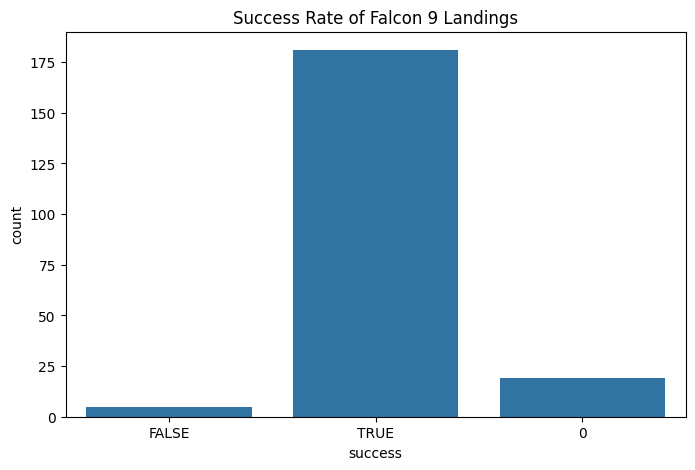

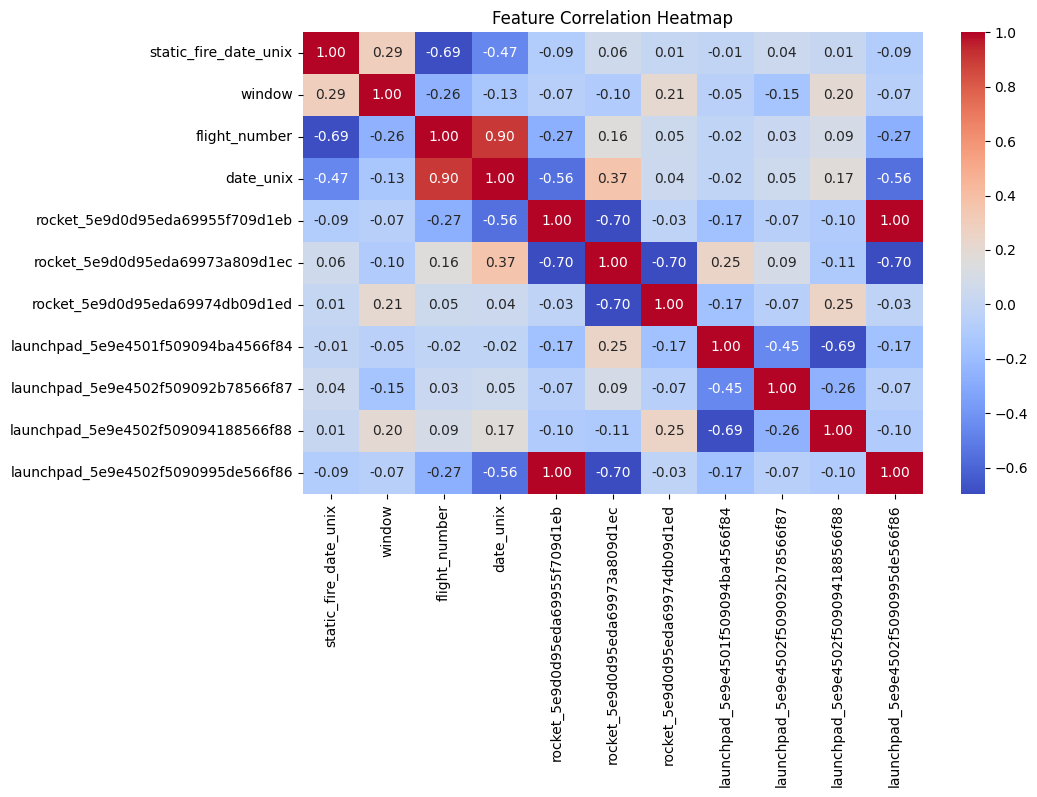

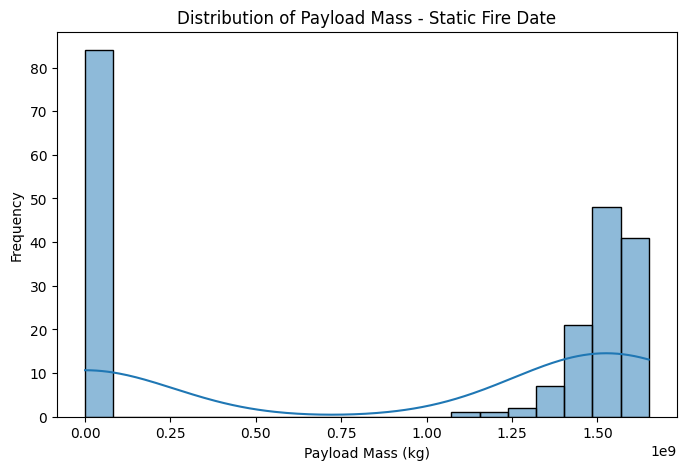

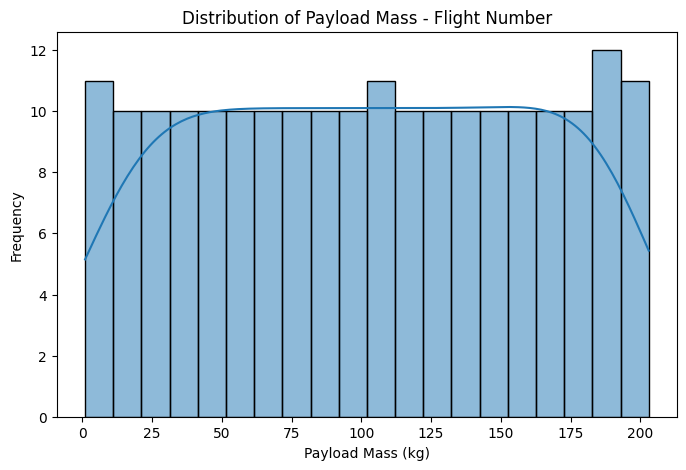

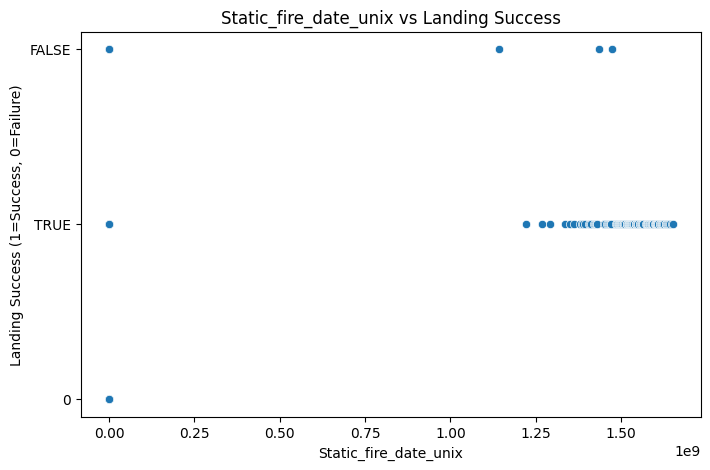

In [5]:
# Visualizing Landing Success
plt.figure(figsize=(8, 5))
sns.countplot(x=df['success'])
plt.title("Success Rate of Falcon 9 Landings")
plt.show()

# Ensure 'static_fire_date_unix' column exists
# Correlation heatmap
plt.figure(figsize=(10, 6))
numeric_df = df_cleaned.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Histogram of Payload Mass
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['static_fire_date_unix'], bins=20, kde=True)
plt.title("Distribution of Payload Mass - Static Fire Date")
plt.xlabel("Payload Mass (kg)")
plt.ylabel("Frequency")
plt.show()

# Histogram of Payload Mass
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['flight_number'], bins=20, kde=True)
plt.title("Distribution of Payload Mass - Flight Number")
plt.xlabel("Payload Mass (kg)")
plt.ylabel("Frequency")
plt.show()

# Scatter Plot: static_fire_date_unix vs Landing Success
plt.figure(figsize=(8, 5))
# Assuming 'success' column represents the landing outcome
sns.scatterplot(x='static_fire_date_unix', y='success', data=df_cleaned)
plt.title("Static_fire_date_unix vs Landing Success")
plt.xlabel("Static_fire_date_unix")
plt.ylabel("Landing Success (1=Success, 0=Failure)")
plt.show()

Feature Selection & Splitting Dataset

In [6]:
# Define features (X) and target variable (y)
# Assuming 'success' column represents the landing outcome
X = df_cleaned.drop(columns=['success'])

# Drop non-numeric columns
X = X.select_dtypes(include=[np.number])

y = df_cleaned['success']

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the columns in df_cleaned
print(list(df_cleaned.columns)[:5])
df.head()

['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window', 'success']


,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,links.article,links.wikipedia,fairings,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86
0,2006-03-17T00:00:00.000Z,1142553600,False,0,FALSE,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
1,0,0,False,0,FALSE,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
2,0,0,False,0,FALSE,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,0,1,0,0,0,0,0,1
3,2008-09-20T00:00:00.000Z,1221868800,False,0,TRUE,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,0,1,0,0,0,0,0,1
4,0,0,False,0,TRUE,[],0,[],[],[],...,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,0,1,0,0,0,0,0,1


Train Multiple Machine Learning Models

In [7]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "SVM": SVC(kernel='linear')
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {accuracy:.4f}")
    df.head()
    print(classification_report(y_test, y_pred))
    df.head()


Logistic Regression Accuracy: 0.9756
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
        TRUE       0.97      1.00      0.99        37

    accuracy                           0.98        41
   macro avg       0.99      0.88      0.92        41
weighted avg       0.98      0.98      0.97        41


Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
        TRUE       1.00      1.00      1.00        37

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41


Decision Tree Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
        TRUE       1.00      1.00      1.00        37

    accuracy                           1.00        41
   macro avg       1.00   

Hyperparameter Tuning (Grid Search CV)

In [8]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for tuning
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Grid Search for Decision Tree Classifier
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best model from Grid Search
best_model = grid_search.best_estimator_
print("\nBest Decision Tree Model:", best_model)
df.head()


Best Decision Tree Model: DecisionTreeClassifier(max_depth=3, random_state=42)


,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,links.article,links.wikipedia,fairings,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86
0,2006-03-17T00:00:00.000Z,1142553600,False,0,FALSE,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
1,0,0,False,0,FALSE,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
2,0,0,False,0,FALSE,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,0,1,0,0,0,0,0,1
3,2008-09-20T00:00:00.000Z,1221868800,False,0,TRUE,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,0,1,0,0,0,0,0,1
4,0,0,False,0,TRUE,[],0,[],[],[],...,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,0,1,0,0,0,0,0,1


Model Evaluation and Confusion Matrix

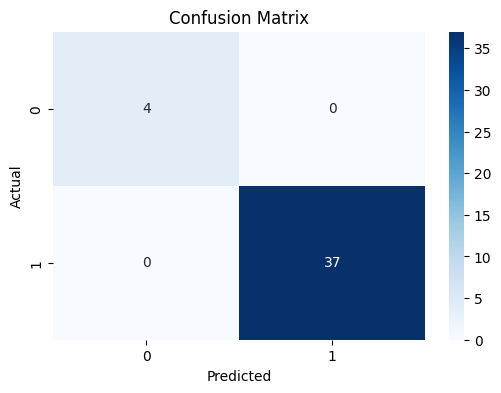

In [9]:
# Predict using the best model
y_pred_best = best_model.predict(X_test_scaled)

# Display Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
print("Unique values in y_test:", np.unique(y_test))
df.head()

Unique values in y_test: ['0' 'TRUE']


,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,links.article,links.wikipedia,fairings,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86
0,2006-03-17T00:00:00.000Z,1142553600,False,0,FALSE,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
1,0,0,False,0,FALSE,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
2,0,0,False,0,FALSE,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,0,1,0,0,0,0,0,1
3,2008-09-20T00:00:00.000Z,1221868800,False,0,TRUE,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,0,1,0,0,0,0,0,1
4,0,0,False,0,TRUE,[],0,[],[],[],...,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,0,1,0,0,0,0,0,1


In [11]:
# Convert labels to numeric (0 and 1)
y_test = np.where(y_test == 'TRUE', 1, 0).astype(int)
y_pred_best = np.where(y_pred_best == 'TRUE', 1, 0).astype(int)

# Verify changes
print("Fixed y_test unique values:", np.unique(y_test))
df.head()


Fixed y_test unique values: [0 1]


,static_fire_date_utc,static_fire_date_unix,net,window,success,failures,details,crew,ships,capsules,...,links.article,links.wikipedia,fairings,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86
0,2006-03-17T00:00:00.000Z,1142553600,False,0,FALSE,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],[],...,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
1,0,0,False,0,FALSE,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],[],...,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,0,1,0,0,0,0,0,1
2,0,0,False,0,FALSE,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],[],...,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,0,1,0,0,0,0,0,1
3,2008-09-20T00:00:00.000Z,1221868800,False,0,TRUE,[],Ratsat was carried to orbit on the first succe...,[],[],[],...,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,0,1,0,0,0,0,0,1
4,0,0,False,0,TRUE,[],0,[],[],[],...,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,0,1,0,0,0,0,0,1


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute precision, recall, and F1-score
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")


✅ Precision: 1.0000
✅ Recall: 1.0000
✅ F1 Score: 1.0000
